In [2]:
import  urllib
import geopandas
import pandas as pd
import numpy as np
import os
import requests
import json
import io
import csv
import shapely
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [252]:
url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'
urllib.request.urlretrieve(url, "file.gz")

('file.gz', <http.client.HTTPMessage at 0x7f786f616438>)

In [253]:
os.system("mv " + "file.gz " + os.getenv("PUIDATA"))
os.system("unzip " + os.getenv("PUIDATA") + "/" + "file.gz")

0

In [254]:
os.system("mv " + "geo_export_3438bf3d-5b3f-4ffe-bb10-931fc57cb6fc.dbf " + os.getenv("PUIDATA"))
os.system("mv " + "geo_export_3438bf3d-5b3f-4ffe-bb10-931fc57cb6fc.prj " + os.getenv("PUIDATA"))
os.system("mv " + "geo_export_3438bf3d-5b3f-4ffe-bb10-931fc57cb6fc.shp " + os.getenv("PUIDATA"))
os.system("mv " + "geo_export_3438bf3d-5b3f-4ffe-bb10-931fc57cb6fc.shx " + os.getenv("PUIDATA"))

256

In [2]:
pumashp = geopandas.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/" +'geo_export_3438bf3d-5b3f-4ffe-bb10-931fc57cb6fc.shp')

In [3]:
pumashp.head()

puma    shape_area     shape_leng  \
0  3701  9.792852e+07   53227.144461   
1  3702  1.889860e+08  106050.002302   
2  3703  2.670137e+08  304071.257466   
3  3704  1.062129e+08   47970.901277   
4  4015  8.105438e+07   50007.415493   

                                            geometry  
0  POLYGON ((-73.89641133483133 40.90450452082026...  
1  POLYGON ((-73.8442314689986 40.86942035096838,...  
2  (POLYGON ((-73.78833349834532 40.8346671297593...  
3  POLYGON ((-73.84792614069238 40.8713422330779,...  
4  POLYGON ((-73.95374853778468 40.63858633758547...

In [4]:
pumashp.crs

{'init': 'epsg:4326'}

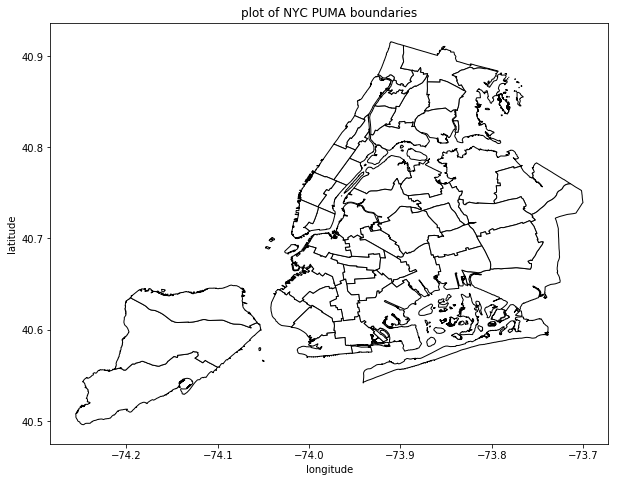

In [5]:
# using the built in plot function as pumashp.plot(pumashp....)
# using a choroplethNYC function that FBB wrote
pumashp.plot(figsize=(10,10), color = 'white', edgecolor = 'black')
plt.title('plot of NYC PUMA boundaries')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

## Caption:
#### Figure 1: The plot of NYC PUMA Boundaries, just the contours of the region. The X-axis is longitude and the Y-axis is latitude.

In [6]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [7]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))


In [8]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type')]

In [9]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [10]:
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'With an Internet subscription!!Broadband of any type' in aff1y['variables'][k]['label']]

[('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type')]

In [11]:
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

In [12]:
#reading in my api key saved in censusAPI.py as
#myAPI = 'XXXXXXXXXXXXXXX'
from censusAPI import myAPI


In [13]:
myAPI = myAPI()

In [14]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

B28002_004E                                               NAME  state  \
0        32607                 St. Lawrence County PUMA, New York     36   
1        50811  Clinton, Franklin, Essex & Hamilton Counties P...     36   
2        41210        Warren & Washington Counties PUMA, New York     36   
3        36075  Herkimer (North & Central) & Oneida (Outer) Co...     36   
4        47786  Oneida County (Central)--Greater Utica & Rome ...     36   

   public use microdata area  Unnamed: 4  
0                        100         NaN  
1                        200         NaN  
2                        300         NaN  
3                        401         NaN  
4                        402         NaN

In [15]:
# getting the number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

B28002_001E                                               NAME  state  \
0        40479                 St. Lawrence County PUMA, New York     36   
1        67092  Clinton, Franklin, Essex & Hamilton Counties P...     36   
2        51614        Warren & Washington Counties PUMA, New York     36   
3        44300  Herkimer (North & Central) & Oneida (Outer) Co...     36   
4        61146  Oneida County (Central)--Greater Utica & Rome ...     36   

   public use microdata area  Unnamed: 4  
0                        100         NaN  
1                        200         NaN  
2                        300         NaN  
3                        401         NaN  
4                        402         NaN

In [16]:
merg = pumaBB.merge(pumaPP, how='left',on='NAME')
merg = merg.drop(['state_y','public use microdata area_y','Unnamed: 4_x','Unnamed: 4_y'], axis=1)

In [17]:
merg['pcBB'] = merg.B28002_004E/merg.B28002_001E * 100
pumaBB = merg
pumaBB.head()

B28002_004E                                               NAME  state_x  \
0        32607                 St. Lawrence County PUMA, New York       36   
1        50811  Clinton, Franklin, Essex & Hamilton Counties P...       36   
2        41210        Warren & Washington Counties PUMA, New York       36   
3        36075  Herkimer (North & Central) & Oneida (Outer) Co...       36   
4        47786  Oneida County (Central)--Greater Utica & Rome ...       36   

   public use microdata area_x  B28002_001E       pcBB  
0                          100        40479  80.552879  
1                          200        67092  75.733321  
2                          300        51614  79.842678  
3                          401        44300  81.433409  
4                          402        61146  78.150656

In [108]:
os.system("unzip " + os.getenv("PUIDATA") + "/" + "ACS_16_1YR_GCT2801.ST50.zip")

0

In [109]:
os.system("mv " + "ACS_16_1YR_GCT2801.ST50_with_ann.csv " + os.getenv("PUIDATA"))
os.system("mv " + "ACS_16_1YR_GCT2801.ST50.txt " + os.getenv("PUIDATA"))
os.system("mv " + "ACS_16_1YR_GCT2801.ST50_metadata.csv " + os.getenv("PUIDATA"))
os.system("mv " + "aff_download_readme_ann.txt " + os.getenv("PUIDATA"))

0

In [18]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])
bbpc.head()

GCT_STUB.target-geo-id2     HC01             HC02
0          Target Geo Id2  Percent  Margin of Error
1                      01     74.7              0.5
2                 0100100     70.9              2.5
3                 0100200     80.5              2.7
4                 0100301     87.0              2.8

In [19]:
bbpc.drop([0,1],inplace=True)

In [20]:
bbpc.head()

GCT_STUB.target-geo-id2  HC01 HC02
2                 0100100  70.9  2.5
3                 0100200  80.5  2.7
4                 0100301  87.0  2.8
5                 0100302  81.9  2.9
6                 0100400  69.2  3.6

In [21]:
bbpc['GCT_STUB.target-geo-id2'] = bbpc['GCT_STUB.target-geo-id2'].astype(int)
bbpc['GCT_STUB.target-geo-id2'] = bbpc['GCT_STUB.target-geo-id2'] - 3600000

In [22]:
bbpc.head()

GCT_STUB.target-geo-id2  HC01 HC02
2                 -3499900  70.9  2.5
3                 -3499800  80.5  2.7
4                 -3499699  87.0  2.8
5                 -3499698  81.9  2.9
6                 -3499600  69.2  3.6

In [23]:
diff_ = pumaBB.merge(bbpc, right_on='GCT_STUB.target-geo-id2', 
                     left_on="public use microdata area_x")[["pcBB", "HC01"]]
diff_["HC01"] = diff_["HC01"].astype(float)
diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

In [24]:
diff_.head()

pcBB  HC01      diff
0  80.552879  80.6  0.047121
1  75.733321  75.7  0.033321
2  79.842678  79.8  0.042678
3  81.433409  81.4  0.033409
4  78.150656  78.2  0.049344

In [25]:
diff_.describe()

pcBB        HC01        diff
count  145.000000  145.000000  145.000000
mean    81.845478   81.843448    0.026217
std      7.063369    7.065358    0.014480
min     54.932945   54.900000    0.000178
25%     77.770257   77.800000    0.012252
50%     82.826141   82.800000    0.027230
75%     87.305077   87.300000    0.039090
max     93.404143   93.400000    0.049872

# 3 Plot a choropleth of NYC broadband access

## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [26]:
pumashp['puma'] = pumashp['puma'].astype(int)

In [27]:
pumaBB['public use microdata area_x'] = pumaBB['public use microdata area_x'].astype(int)

In [28]:
#choropleth of the percentage of internet axcess
mm = pumashp.merge(pumaBB,left_on='puma',right_on='public use microdata area_x')

# cp.choroplethNYC(...);

In [29]:
mm.head()

puma    shape_area     shape_leng  \
0  3701  9.792852e+07   53227.144461   
1  3702  1.889860e+08  106050.002302   
2  3703  2.670137e+08  304071.257466   
3  3704  1.062129e+08   47970.901277   
4  4015  8.105438e+07   50007.415493   

                                            geometry  B28002_004E  \
0  POLYGON ((-73.89641133483133 40.90450452082026...        35529   
1  POLYGON ((-73.8442314689986 40.86942035096838,...        34030   
2  (POLYGON ((-73.78833349834532 40.8346671297593...        36716   
3  POLYGON ((-73.84792614069238 40.8713422330779,...        32269   
4  POLYGON ((-73.95374853778468 40.63858633758547...        44079   

                                                NAME  state_x  \
0  NYC-Bronx Community District 8--Riverdale, Fie...       36   
1  NYC-Bronx Community District 12--Wakefield, Wi...       36   
2  NYC-Bronx Community District 10--Co-op City, P...       36   
3  NYC-Bronx Community District 11--Pelham Parkwa...       36   
4  NYC-Brooklyn Community District 14--Flatbush &...       36   

   public use microdata area_x  B28002_001E       pcBB  
0                         3701        42158  84.275820  
1                         3702        49817  68.310015  
2                         3703        44329  82.826141  
3                         3704        44476  72.553737  
4                         4015        55953  78.778618

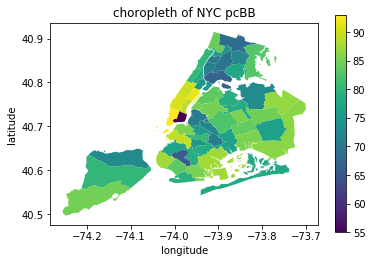

In [36]:
mm.plot(column='pcBB',legend=True)
plt.title('choropleth of NYC pcBB')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

### Caption: Figure 2. The choropleth of NYU pcBB. The x-axis is longitude, the y-axis is latitude. The color in this plot reprecents different value.

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed

In [3]:
linkNYC = pd.read_csv(os.getenv("PUIDATA") + "/" +"linkNYClocations.csv")

In [4]:
linkNYC.head()

Unnamed: 0     link_site  longitude  date_link_   latitude
0           0  bk-01-138951 -73.942489  2017-07-01  40.701668
1           1  bk-01-109091 -73.942169  2017-07-01  40.701542
2           2  bk-01-143982 -73.942239  2017-07-01  40.701930
3           3  bk-01-109262 -73.942918  2017-04-28  40.705060
4           4  bk-01-125268 -73.953439  2017-03-31  40.728133

In [129]:
linkNYC.shape

(1414, 5)

## combine long lat into a column like you did in the lab to greate a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame linkNYC and set native coordinates frame to lat/lon as you did in the la

In [130]:
# combine lat and lon to one column
linkNYC['lonlat']=list(zip(linkNYC.longitude,linkNYC.latitude))
# Create Point Geometry for based on lonlat column
linkNYC['geometry']=linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC=geopandas.GeoDataFrame(linkNYC)
linkNYC.head()

Unnamed: 0     link_site  longitude  date_link_   latitude  \
0           0  bk-01-138951 -73.942489  2017-07-01  40.701668   
1           1  bk-01-109091 -73.942169  2017-07-01  40.701542   
2           2  bk-01-143982 -73.942239  2017-07-01  40.701930   
3           3  bk-01-109262 -73.942918  2017-04-28  40.705060   
4           4  bk-01-125268 -73.953439  2017-03-31  40.728133   

                            lonlat                                  geometry  
0      (-73.94248859, 40.70166753)          POINT (-73.94248859 40.70166753)  
1  (-73.9421692831, 40.7015421938)      POINT (-73.9421692831 40.7015421938)  
2  (-73.9422392385, 40.7019303439)  POINT (-73.94223923850001 40.7019303439)  
3      (-73.94291758, 40.70506042)          POINT (-73.94291758 40.70506042)  
4          (-73.953439, 40.728133)              POINT (-73.953439 40.728133)

## plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in 5 equal intervals

In [131]:
linkNYC['date_link_'] = pd.datetime(year=2018,month=10,day=20)-pd.to_datetime(linkNYC['date_link_'])

In [132]:
linkNYC.head()

Unnamed: 0     link_site  longitude  date_link_   latitude  \
0           0  bk-01-138951 -73.942489    476 days  40.701668   
1           1  bk-01-109091 -73.942169    476 days  40.701542   
2           2  bk-01-143982 -73.942239    476 days  40.701930   
3           3  bk-01-109262 -73.942918    540 days  40.705060   
4           4  bk-01-125268 -73.953439    568 days  40.728133   

                            lonlat                                  geometry  
0      (-73.94248859, 40.70166753)          POINT (-73.94248859 40.70166753)  
1  (-73.9421692831, 40.7015421938)      POINT (-73.9421692831 40.7015421938)  
2  (-73.9422392385, 40.7019303439)  POINT (-73.94223923850001 40.7019303439)  
3      (-73.94291758, 40.70506042)          POINT (-73.94291758 40.70506042)  
4          (-73.953439, 40.728133)              POINT (-73.953439 40.728133)

In [133]:
linkNYC['date_link_'] = linkNYC['date_link_'].astype(int)

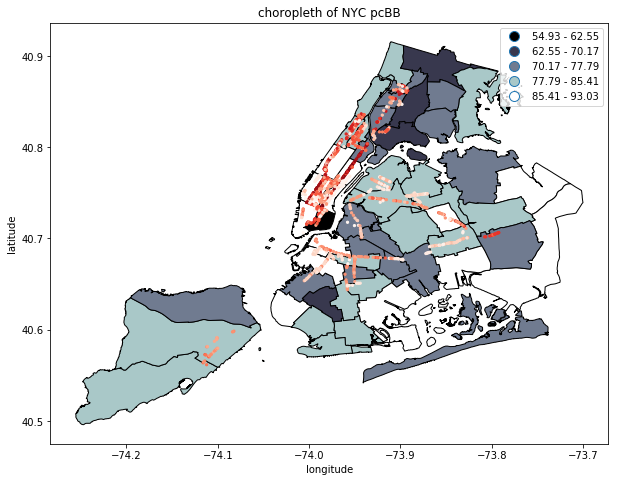

In [154]:
base = mm.plot(figsize = (10,15),column='pcBB',legend=True,scheme='Equal_interval',cmap='bone',edgecolor = 'black')
linkNYC.plot(ax=base,marker = 'o',column='date_link_',cmap='Reds',markersize=5)
plt.title('choropleth of NYC pcBB')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

## Caption: Figure 3. The location of the linkNYC stations on top of a choropleth of broadband access percentage in 5 equal intervals.  The x-axis is longitude, the y-axis is latitude. 

## 5 Find the number of linkNYC locations per person by PUMA

### 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

In [378]:
keyNhouseholds='B00001_001E'
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPop.head()

B00001_001E                                               NAME  state  \
0         3075                 St. Lawrence County PUMA, New York     36   
1         4356  Clinton, Franklin, Essex & Hamilton Counties P...     36   
2         2736        Warren & Washington Counties PUMA, New York     36   
3         2722  Herkimer (North & Central) & Oneida (Outer) Co...     36   
4         2874  Oneida County (Central)--Greater Utica & Rome ...     36   

   public use microdata area  Unnamed: 4  
0                        100         NaN  
1                        200         NaN  
2                        300         NaN  
3                        401         NaN  
4                        402         NaN

## 5.2 find the number of station per 100 people per PUMA

In [379]:
pumashp = pumashp.to_crs(epsg=2263)

In [380]:
linkNYC['link_site'] = 1

In [381]:
linkNYC.crs = {'init': 'epsg:2263', 'no_defs': True}

In [398]:
linkNYC = linkNYC.to_crs(epsg=2263)

In [432]:
linkpp = geopandas.sjoin(linkNYC,pumashp,how = 'left',op='intersects').groupby('puma').sum()
linkpp.drop(['longitude','Unnamed: 0','date_link_','latitude','index_right','shape_area','shape_leng'],axis=1,inplace=True)

In [433]:
linkpp.head()

link_site
puma           
3701        1.0
3705        1.0
3706       20.0
3707       29.0
3708       19.0

In [434]:
hh = pumashp.merge(linkpp,how='outer',left_on='puma',right_index=True)

In [449]:
pumashplc = pumaPop.merge(hh,how='inner',left_on='public use microdata area',right_on='puma')

In [454]:
pumashplc["linkNYCp100p"] = pumashplc['link_site']/pumashplc['B00001_001E'] *100

In [451]:
#linkNYC per 100 inhabitants
pumashplc["linkNYCp100p"].describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: linkNYCp100p, dtype: float64

In [452]:
pumashplc["linkNYCp100p"] = pumashplc["linkNYCp100p"].astype(float)
pumashplc = geopandas.GeoDataFrame(pumashplc)

In [453]:
pumashplc.head(1)

B00001_001E                                               NAME  state  \
0         1517  NYC-Bronx Community District 8--Riverdale, Fie...     36   

   public use microdata area  Unnamed: 4  puma    shape_area    shape_leng  \
0                       3701         NaN  3701  9.792852e+07  53227.144461   

                                            geometry  link_site  linkNYCp100p  
0  POLYGON ((1012885.033996583 268830.4841915747,...        1.0       0.06592

## at last, plot the linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


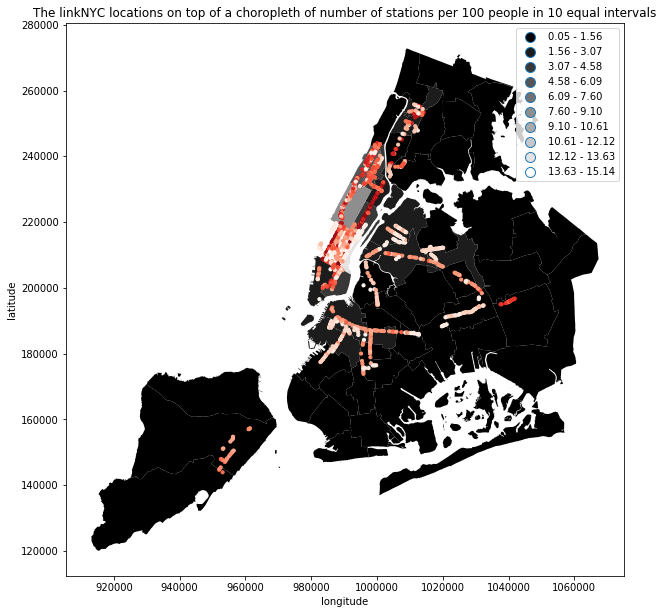

In [467]:
base = pumashplc.plot(figsize = (10,15),column='linkNYCp100p',legend=True,scheme='Equal_interval',cmap='gist_gray',k=10)

linkNYC.plot(ax=base,marker = 'o',column='date_link_',cmap='Reds',markersize=10)
plt.title('The linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

## Caption: Figure 4. The x-axis is longitude, the y-axis is latitude.The linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals